In [60]:
import pandas as pd
import numpy as np
import statsmodels as sm
import sklearn as skl
import sklearn.preprocessing as preprocessing
import sklearn.linear_model as linear_model
#import sklearn.cross_validation as cross_validation
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import sklearn.tree as tree
import matplotlib.pyplot as plt
import seaborn as sns
import math

## Read the data

In [61]:
original_data = pd.read_csv(
    "adult.data.txt",
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"],
        sep=r'\s*,\s*',
        engine='python',
        na_values="?")
original_data.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [62]:
#original_data['new_target'] = original_data['Target']

In [63]:
#original_data.loc[original_data.new_target != '<=50K', 'new_target'] = 0
#original_data.loc[original_data.new_target == '<=50K', 'new_target'] = 1

In [64]:
original_data_new=original_data

In [65]:
#original_data_new=original_data_new.drop(["Target"], axis=1)
original_data_new.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [67]:
#original_data_new["new_target"].value_counts()

## Analyze the data

* Let’s plot the distribution of each feature, so that we have a better understanding what we have in our data. We draw the number of values for each category feature and the histogram of the values for each continuous feature.

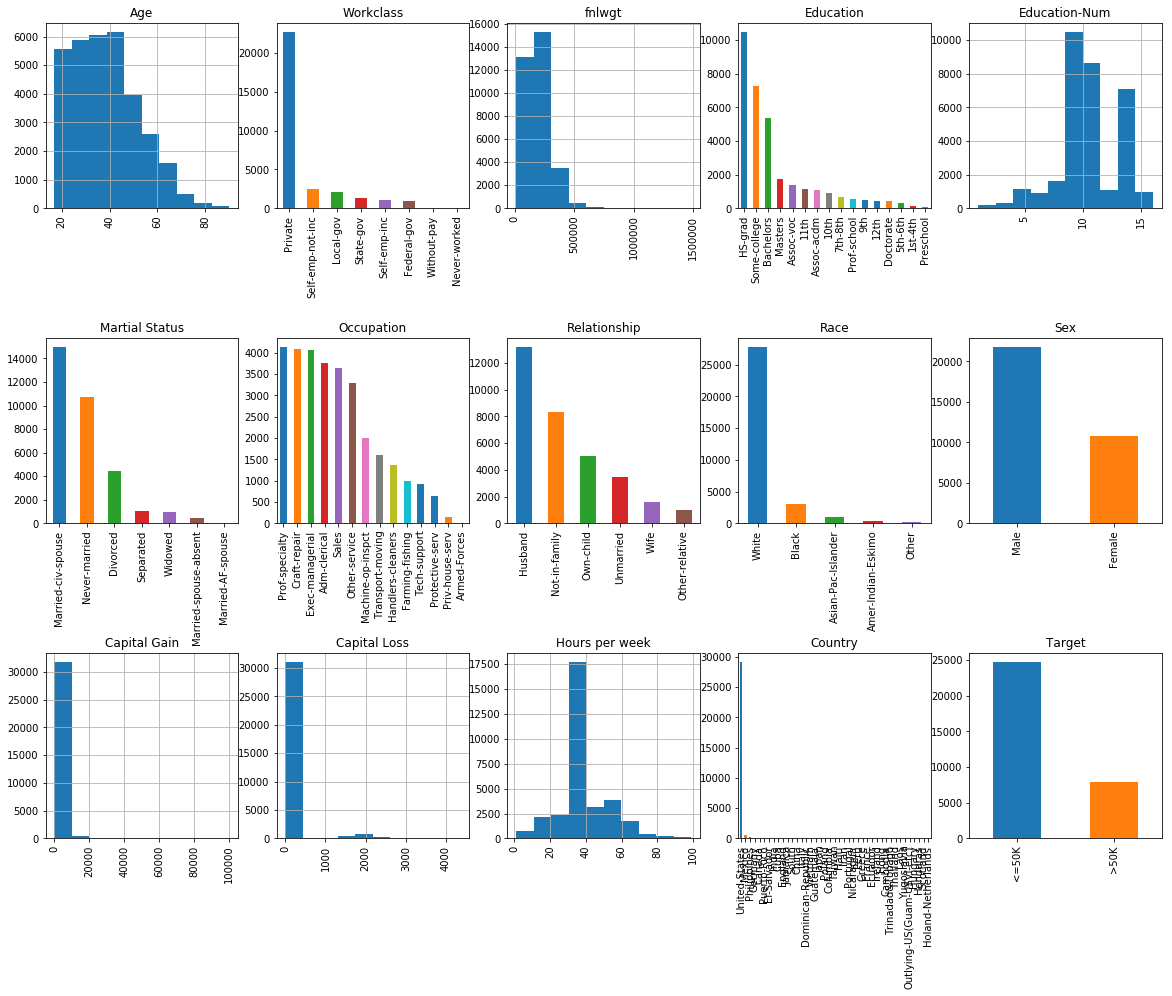

In [68]:
fig = plt.figure(figsize=(20,15))
cols = 5
rows = math.ceil(float(original_data.shape[1]) / cols)
for i, column in enumerate(original_data_new.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if original_data_new.dtypes[column] == np.object:
        original_data_new[column].value_counts().plot(kind="bar", axes=ax)
    else:
        original_data_new[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

## As you can see from the plots above our data is mostly concentrated in the USA with mostly male white people. This is a good thing to notice, as it may impact the conclusions we come to later

In [69]:
(original_data_new["Country"].value_counts() / original_data_new.shape[0]).head()

United-States    0.895857
Mexico           0.019748
Philippines      0.006081
Germany          0.004207
Canada           0.003716
Name: Country, dtype: float64

* Indeed! 89% of the samples are for people from the US. Mexico comes next with less than 2%.

* Now, let’s explore something else. The correlation between the different features. Generally it is not a good idea to have many correlated features, as it might be a sign that your data is not very good. For this purpose we will need to encode the categorical features as numbers. This can be done using the LabelEncoder in the scikit-learn package.

In [70]:
original_data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
Age               32561 non-null int64
Workclass         30725 non-null object
fnlwgt            32561 non-null int64
Education         32561 non-null object
Education-Num     32561 non-null int64
Martial Status    32561 non-null object
Occupation        30718 non-null object
Relationship      32561 non-null object
Race              32561 non-null object
Sex               32561 non-null object
Capital Gain      32561 non-null int64
Capital Loss      32561 non-null int64
Hours per week    32561 non-null int64
Country           31978 non-null object
Target            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [71]:
# Encode the categorical features as numbers
def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders


In [73]:
#original_data_new["new_target"].value_counts()
original_data_new.isnull().sum()

Age                  0
Workclass         1836
fnlwgt               0
Education            0
Education-Num        0
Martial Status       0
Occupation        1843
Relationship         0
Race                 0
Sex                  0
Capital Gain         0
Capital Loss         0
Hours per week       0
Country            583
Target               0
dtype: int64

In [74]:
original_data_new["Workclass"].fillna("UNKNOWN", inplace=True)

In [75]:
original_data_new["Occupation"].fillna("UNKNOWN", inplace=True)

In [76]:
original_data_new["Country"].fillna("UNKNOWN", inplace=True)

In [77]:
original_data_new.isnull().sum()

Age               0
Workclass         0
fnlwgt            0
Education         0
Education-Num     0
Martial Status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital Gain      0
Capital Loss      0
Hours per week    0
Country           0
Target            0
dtype: int64

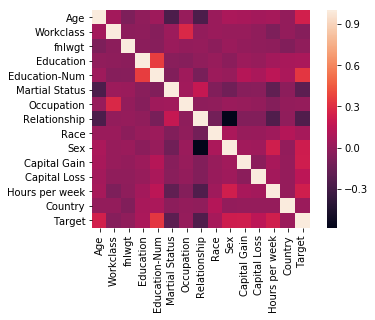

In [78]:
# Calculate the correlation and plot it
encoded_data, _ = number_encode_features(original_data_new)
sns.heatmap(encoded_data.corr(), square=True)
plt.show()
#original_data_new.corr()

In [79]:
del original_data_new["Education"]

* So it seems that the data is mostly OK with the exception of Sex and Relationship, which seems to be negatively correlated. Let’s explore that for a bit

In [82]:
original_data[["Sex", "Relationship"]].head(15)

,Sex,Relationship
0,Male,Not-in-family
1,Male,Husband
2,Male,Not-in-family
3,Male,Husband
4,Female,Wife
5,Female,Wife
6,Female,Not-in-family
7,Male,Husband
8,Female,Not-in-family
9,Male,Husband


* Yes. The data looks correlated, because for example Male and Husband are highly correlated values, as well as Female and Wife. There is no easy way to tackle this problem, so let’s carry on.

## Build a classifier

* Now that we explored our data, let’s try to build a classifier which tries to predict what will be the income of a given person given the features we have in our dataset.

* First we need to encode the features as numbers as the classifiers cannot work with string features. As we saw a while ago this can be achieved easily with the function we defined earlier. Let’s encode the data and show the histograms of the values again.

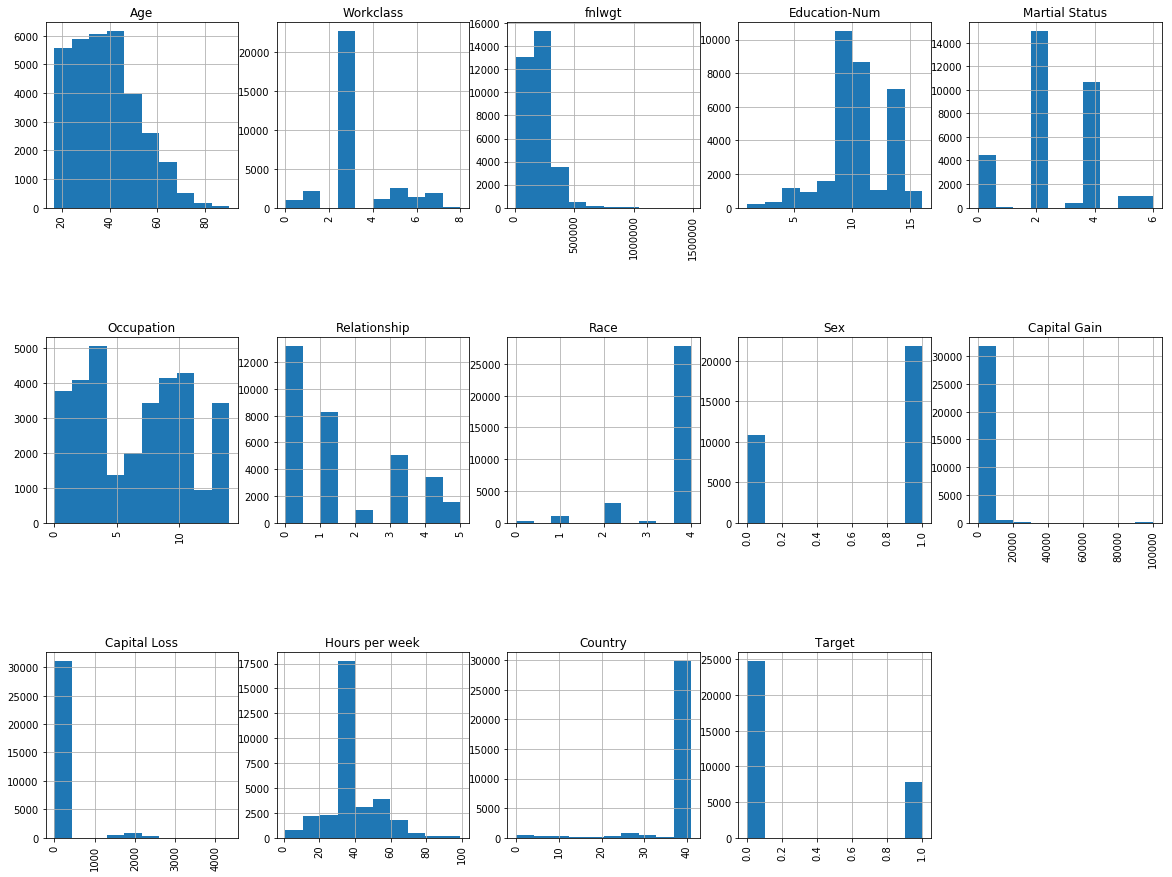

In [83]:
encoded_data, encoders = number_encode_features(original_data_new)
fig = plt.figure(figsize=(20,15))
cols = 5
rows = math.ceil(float(encoded_data.shape[1]) / cols)
for i, column in enumerate(encoded_data.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    encoded_data[column].hist(axes=ax)
    plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

* As you can see we have our data properly encoded and it seems to make sense. Now, let’s try to build a classifier for it. Before we do that, let’s split the data into a train and test set. This is a common approach to avoid overfitting. If we train and test the classifiers on the same data we will always get awesome results and we will most probably overfit the model. However if we test a classifier on data it has never seen we can be more confident it will perform better when ran on new data

## Split and scale the features

* Most machine learning algorithms like the features to be scaled with mean 0 and variance 1. This is called “removing the mean and scaling to unit variance”. This can be easily done with the StandardScaler from scikit-learn. Let’s scale the features and look at them again.

In [92]:
X=encoded_data.drop(['Target'],axis=1)
Y=encoded_data['Target']
encoded_data.head()

,Age,Workclass,fnlwgt,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,6,77516,13,4,0,1,4,1,2174,0,40,39,0
1,50,5,83311,13,2,3,0,4,1,0,0,13,39,0
2,38,3,215646,9,0,5,1,4,1,0,0,40,39,0
3,53,3,234721,7,2,5,0,2,1,0,0,40,39,0
4,28,3,338409,13,2,9,5,2,0,0,0,40,4,0


In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.70, random_state= 10)
scaler = preprocessing.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = scaler.transform(X_test)

## Logistic regressionAnchor

F1 score: 0.557810


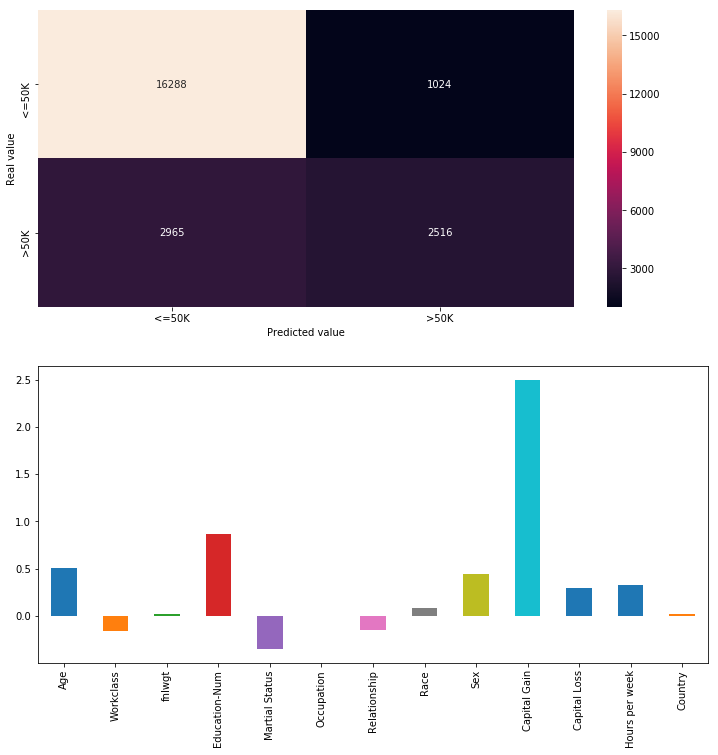

In [109]:
cls = linear_model.LogisticRegression()

cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=encoders["Target"].classes_, yticklabels=encoders["Target"].classes_)
plt.ylabel("Real value")
plt.xlabel("Predicted value")
print("F1 score: %f" % skl.metrics.f1_score(y_test, y_pred))
coefs = pd.Series(cls.coef_[0], index=X_train.columns)
coefs.sort_values()
plt.subplot(2,1,2)
coefs.plot(kind="bar")
plt.show()

* As you can see we managed to achieve F1 score of 0.57 and the features that seems to contribute most positively to have an income of more than $50K are Capital Gain, Education-Num and Sex, while the features that contribute most negatively are Martia Status and Relationship. There is a problem here, though. Features like Martial Status have values ranging from 0 to 6 and the order is really important here. In practice there is no particular order in that feature (unlike Education-Num for which the higher the number, the better the education). We can fix this using binary features.

## Classify using binary features

* As a last step we can try to improve our classifier using binary attributes. Our current approach for encoding our data has the drawback that we put arbitrary order in our classes. For example we encode Relationship with a number between 1 and 5 and the logistic regression interprets these values as continuous variables and plugs them into an optimization function. This will cause different classes to have different weight into our model, which is not correct. Each class is theoretically equally weighted compared to the rest of the classes. In order to fix this we can use dummy variables.

In [110]:
binary_data = pd.get_dummies(original_data_new)
# Let's fix the Target as it will be converted to dummy vars too
binary_data["Target"] = binary_data["Target_>50K"]

In [113]:
BX=binary_data.drop(["Target"],axis=1)
BY=binary_data["Target"]
binary_data.head()

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week,Workclass_Federal-gov,Workclass_Local-gov,Workclass_Never-worked,Workclass_Private,...,Country_Scotland,Country_South,Country_Taiwan,Country_Thailand,Country_Trinadad&Tobago,Country_UNKNOWN,Country_United-States,Country_Vietnam,Country_Yugoslavia,Target
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,38,215646,9,0,0,40,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,53,234721,7,0,0,40,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,28,338409,13,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [112]:
del binary_data["Target_<=50K"]
del binary_data["Target_>50K"]
plt.subplots(figsize=(20,20))
sns.heatmap(binary_data.corr(), square=True)
plt.show()

KeyError: 'Target_<=50K'

* Now we have a bunch of features that have only the values 0 and 1. There is a lot of correlation between some of them, but let’s not look at this for now (for example Male and Female are negatively correlated).

In [107]:
X_train, X_test, y_train, y_test = train_test_split(binary_data, Y, test_size=0.70, random_state= 10)
scaler = preprocessing.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = scaler.transform(X_test)